---
---

# <center><font color='black'>Density Estimation</font></center> <a class="tocSkip">
    
### <center><font color='black'>Nicolai Haug</font></center> <a class="tocSkip">
    
### <center><font color='black'>2021</font></center> <a class="tocSkip">
    
---
---

# Table of Contents <a class="tocSkip">

* [Introduction](#introduction)
    * [Configure Notebook](#configure) 
* [Histograms and Binning](#)
    * [Number of Bins and Width](#)
        * [The Square-root Rule](#)
        * [Sturges' Rule](#)
        * [Scott's Rule](#)
        * [Freedman-Diaconis Rule](#)
* [Kernel Density Estimation](#)

# Introduction <a name="introduction"></a> 

The probability density function (pdf) is a fundamental concept in statistics. In the following, we will discuss **density estimation**, i.e., how to construct an estimate of the pdf from sample data. The likelihood-free inference methods are based on sampling parameters and estimating the posterior from the samples, and hence is density estimation a crucial topic to address. As we will see, density estimation can give representations that have qualitatively different features and lead to entirely different interpretation of the data. 

## Configure Notebook <a name="configure"></a>

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-exclamation-circle" aria-hidden="true"></i>&nbsp; Important</b><br>
    <p style="color: black">
        Run the cell below to configure the notebook. 
    </p>
<div>
</div>
</div>

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from IPython.display import display
from latex_envs.latex_envs import figcaption 
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import default_rng

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

#plt.style.use('seaborn')
sns.set()
sns.set_context("paper")
sns.set_style("darkgrid", {"axes.facecolor": "0.96"})

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          #'legend.handlelength': 2
         }
plt.rcParams.update(params)
plt.rc('text', usetex=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Histograms and Binning

The most basic density estimator is the histogram [[1]](#references). A histogram is an approximate representation of data that divides the data into discrete bins and counts the number of points that fall in each bin. In a more general mathematical sense, a histogram is defined as follows [[1]](#references). We denote the density estimator by $\hat{f}$ and assume we are given a sample of $n$ observations $X_1, ..., X_n$ whose underlying density is to be estimated. Given an origin $x_0$ and a bin width $h$, the bins of the histogram are defined as the intervals $[x_0 + mh, x_0 + (m+1)h)$ for $m$ positive and negative integers. The histogram is then defined by

\begin{equation*}
    \hat{f}(x) = \frac{1}{nh} \times (\text{no. of } X_i \text{ in the same bin as } x)
\end{equation*}

The histogram can be generalized by allowing the bin widths to vary. Then the estimate becomes 

\begin{equation*}
    \hat{f}(x) = \frac{1}{n} \times \frac{(\text{no. of } X_i \text{ in the same bin as } x)}{\text{width of bin containing }x}
\end{equation*}

For instance, if we create some data that is drawn from a mixture density of two normal distributions, a simple  histogram, that is normalized such that the height of the bins reflects density instead of counts and have equal-width bins, will give the following representation of the data: 

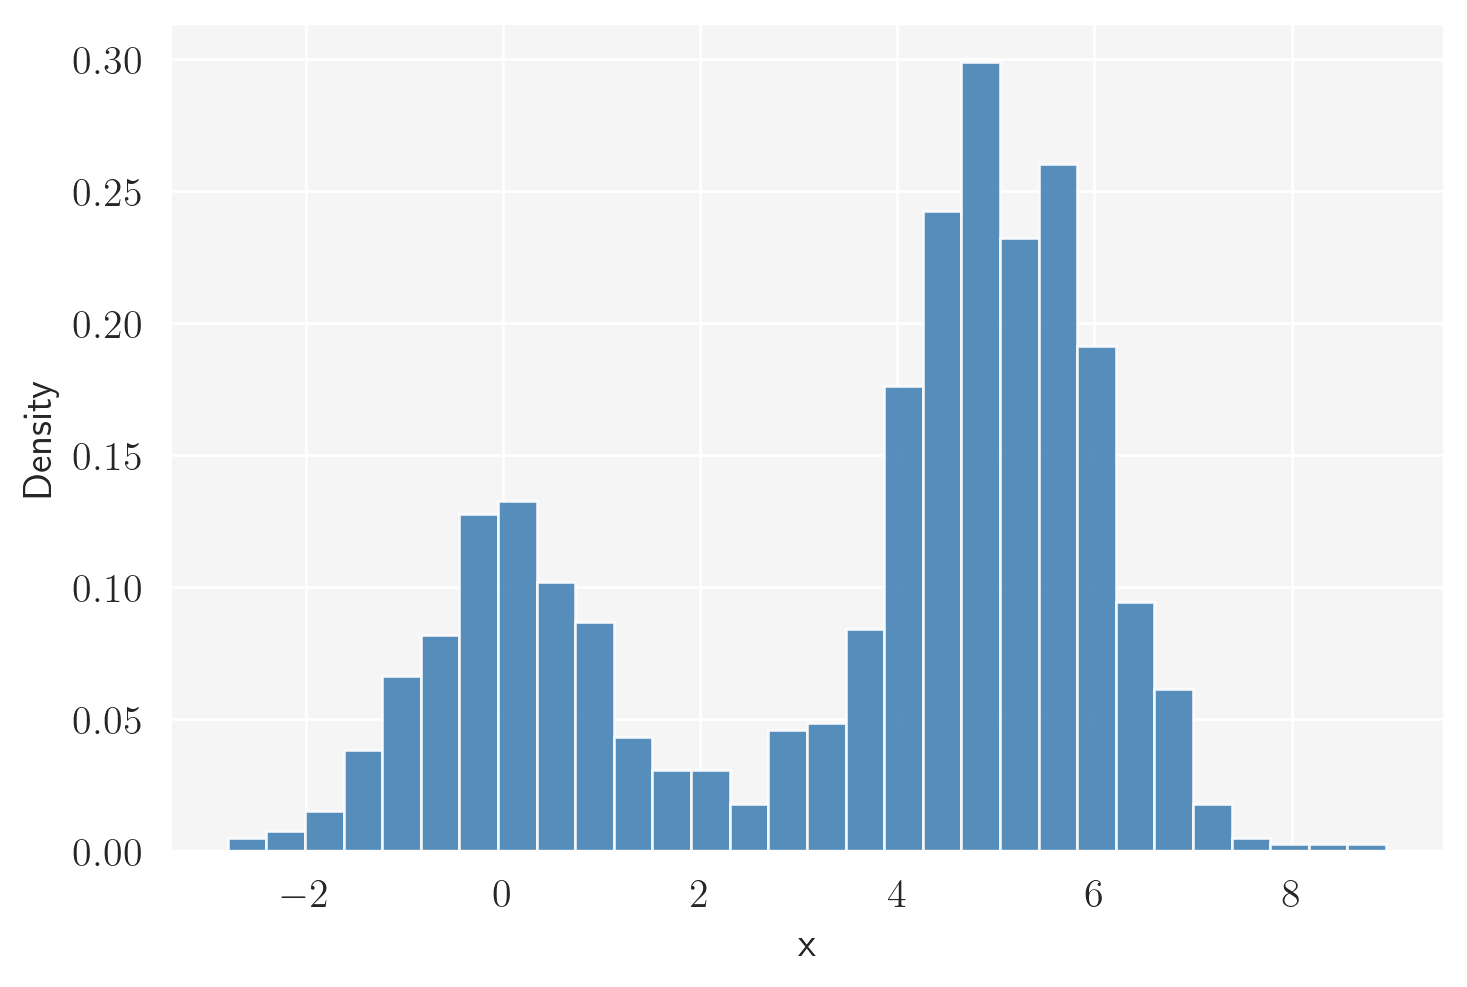

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x


x = make_data(1000)

fig = plt.figure(figsize=(6, 4), constrained_layout=True, dpi=120)
hist = plt.hist(
    x,
    bins=30,
    density=True,
    histtype='bar',
    edgecolor=None,
    color='steelblue',
    alpha=0.9,
)
plt.xlabel("x")
plt.ylabel("Density")
plt.show()
figcaption("Density estimation by the histogram density estimator of\
    1000 observed data samples drawn from a mixed density of\
    two normal distributions divided into 30 bins.")

The preceding figure illustrates why histograms are an immensely useful class of density estimates; they visualize data in an intuitive manner which is key for the presentation and exploration of data. The histogram makes clear that the data is drawn from a bimodal normal distribution.

One of the issues with using a histogram as a density estimator, however, is that the exact visual appearance depends on the choice of bin width (or number of bins) [[2]](#references). Different bin widths can give representations that have qualitatively different features and lead to entirely different interpretation of the data. Consider the following example where we draw 20 samples from the same distribution as before and use two histograms with different bin widths as density estimators:

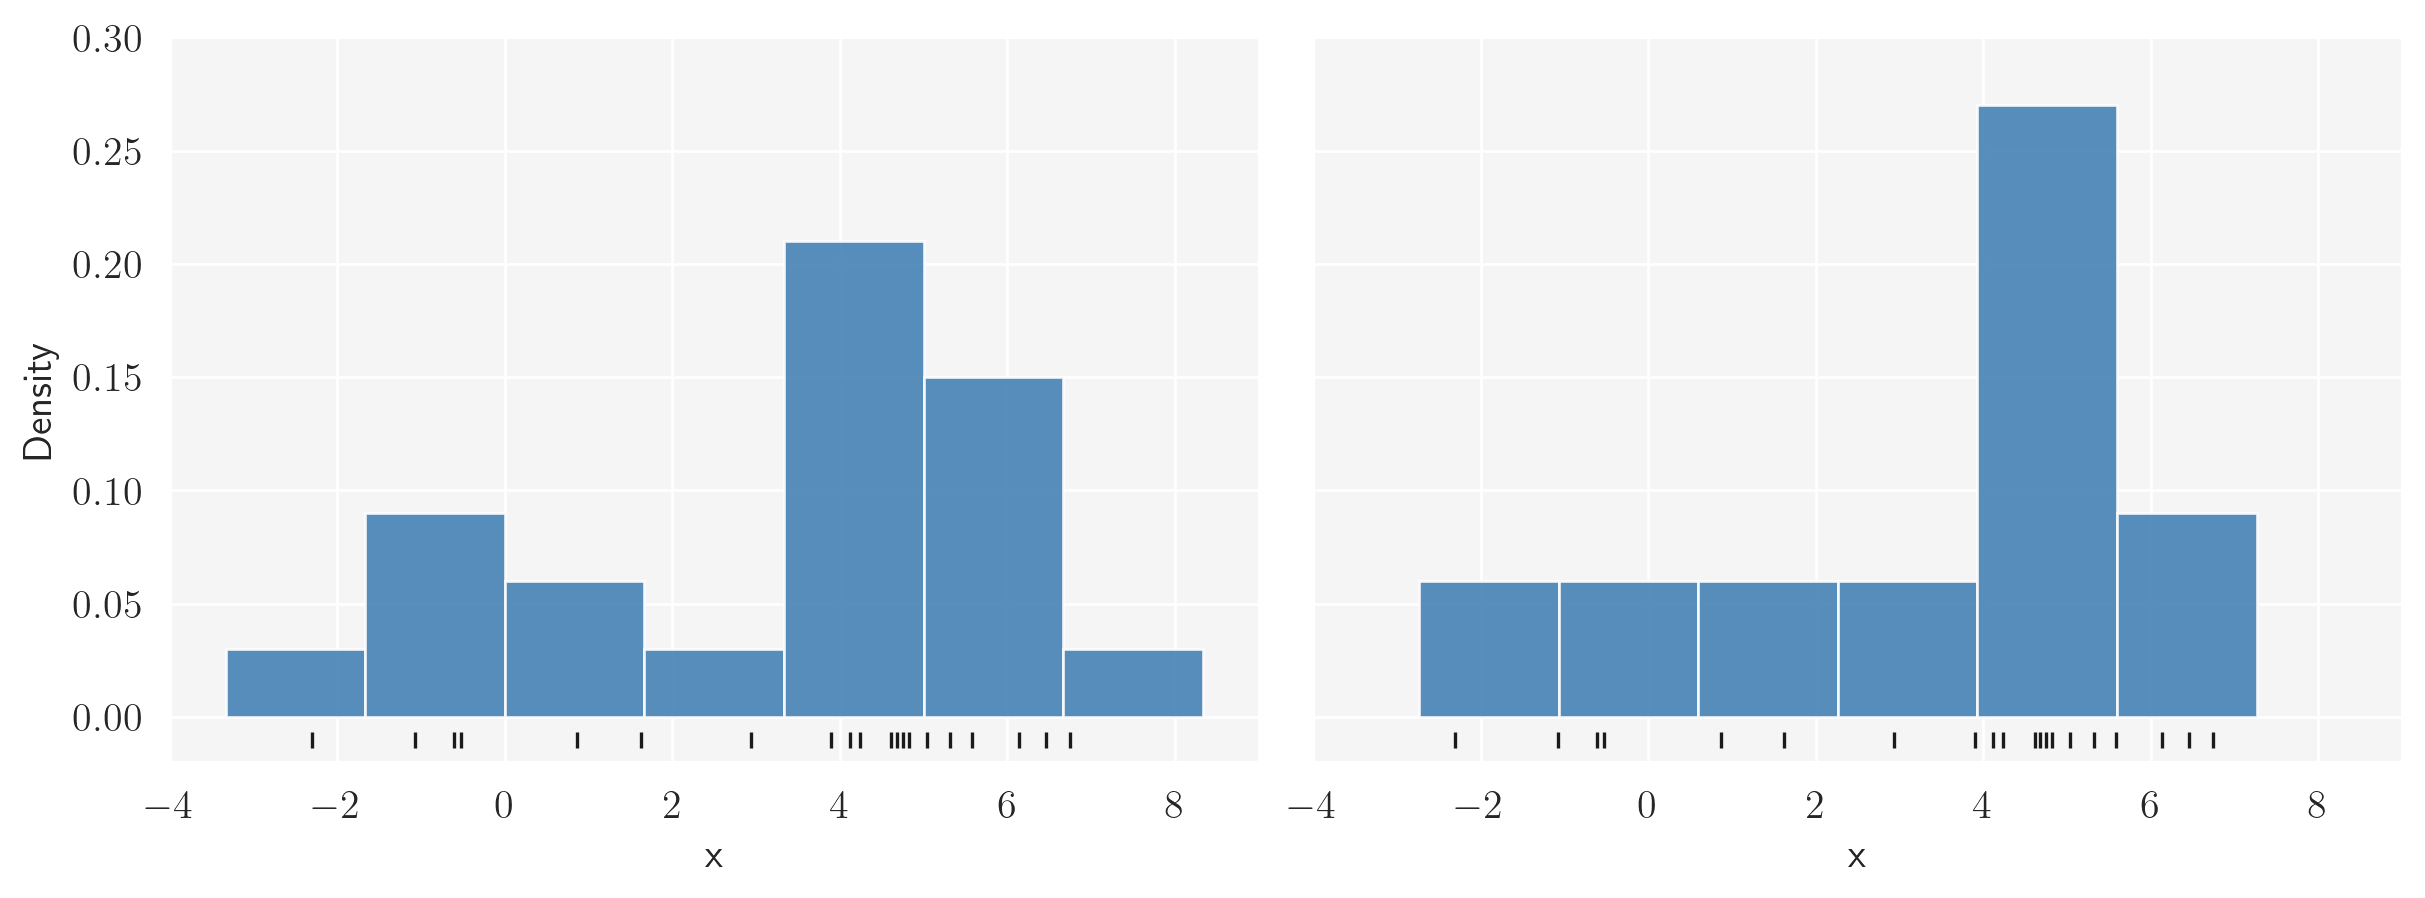

In [7]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 4),
                       sharex=True,
                       sharey=True,
                       subplot_kw={
                           'xlim': (-4, 9),
                           'ylim': (-0.02, 0.3)
                       },
                       dpi=120)
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(
        x,
        bins=bins + offset,
        density=True,
        histtype='bar',
        edgecolor=None,
        color='steelblue',
        alpha=0.9,
    )
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax[i].set_xlabel("x")

ax[0].set_ylabel("Density")
plt.show()
figcaption(
    "These histograms are built from the same data, but with different bin widths.\
    Together they illustrate one of the issues with using histograms as density estimators;\
    the choice of bin widths can lead to vastly different representations of the data."
)

Without knowing that these two histograms were built from the same data, we probably would not have guessed so. The histogram on the left indicates a bimodal distribution as before, but the histogram on the right only shows a unimodal distribution with a long tail.   

## Number of Bins and Width 

There are no hard-and-fast rules concerning the bin width, and in extension the number of bins [[3, p. 16]](#references). The number of bins $k$ can be assigned directly or can be calculated from a suggested bin width $h$ as:

\begin{equation}
    k = \left \lceil \frac{\mathrm{max}\, x - \mathrm{min}\, x}{h} \right \rceil, 
\end{equation}

where $x$ is the sample data with $n$ observations. The braces indicate the ceiling function.

Smaller bin widths can make the histogram cluttered and larger bin widths may obscure nuances in the data. There are however some commonly-used rules-of-thumb, each of which has its own strengths and weaknesses. 

### The Square-root Rule 

Generally, the larger the number of observations in the sample data, the more bins should be used [[3, p. 16]](#references). A reasonable rule of thumb is to take the square root of the number of observations in the sample and round to the next integer:

\begin{equation}
    k = \left \lceil \sqrt{n} \right \rceil 
\end{equation}

**Pros and Cons:** TODO


### Sturges' Rule

**Rewrite, borrowed in it's entirety from Wikipedia**

Sturges' formula is derived from a binomial distribution and implicitly assumes an approximately normal distribution.

\begin{equation}
    k = \left \lceil \log_2 n \right \rceil + 1 
\end{equation}

It implicitly bases the bin sizes on the range of the data and can perform poorly if n < 30, because the number of bins will be small — less than seven — and unlikely to show trends in the data well. It may also perform poorly if the data are not normally distributed.

### Scott's Rule

\begin{equation}
    h = \frac{3.49 \hat{\sigma}}{\sqrt[3]{n}},
\end{equation}

where $\hat{\sigma}$ is the sample standard deviation. Scott's normal reference rule is optimal for random samples of normally distributed data, in the sense that it minimizes the integrated mean squared error of the density estimate. 

### Freedman-Diaconis Rule 

\begin{equation}
    h = 2 \frac{\mathrm{IQR}(x)}{\sqrt[3]{n}},
\end{equation}

which is based on the interquartile range, denoted by $\mathrm{IQR}$. It replaces $3.5\sigma$ of Scott's rule with $2\,\mathrm{IQR}$, which is less sensitive than the standard deviation to outliers in data.

### Knuth's Rule 

Knuth's rule is a fixed-width, Bayesian approach to determining the optimal bin width of a histogram. The optimal number of bins is the value $M$ which maximizes the function 

\begin{equation}
    F(M \mid x, I) = n \log(M) + \log \Gamma \left(\frac{M}{2} \right) - \log \Gamma \left(\frac{1}{2} \right) - \log \Gamma \left(\frac{2n + M}{2} \right) + \sum_{k=1}^{M} \log \Gamma \left(n_k \frac{1}{2} \right),
\end{equation}

where $\Gamma$ is the gamma function, $n$ is the number of data points, $n_k$ is the number of measurements in bin $k$.

In [4]:
def square_root_rule(x):
    """
    Calculate number of histogram bins using the Square-root Rule.
    """
    x = np.asarray(x)
    n = x.size
    k = int(np.ceil(np.sqrt(n)))
    return k


def sturges_rule(x):
    """
    Calculate number of histogram bins using the Sturges' Rule.
    """
    x = np.asarray(x)
    n = x.size
    k = int(np.ceil(np.log2(n)) + 1)
    return k


def scotts_rule(x):
    """
    Calculate number of histogram bins using the Square-root Rule.
    """
    x = np.asarray(x)
    n = x.size
    h = 3.49 * np.std(x) * n**(-1 / 3)
    k = int(np.ceil((x.max() - x.min()) / h))
    return k

def freedman_diaconis_rule(x):
    """
    Calculate number of histogram bins using Freedman-Diaconis rule.
    """
    x = np.asarray(x)
    n = x.size
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    h = 2 * iqr * n**(-1 / 3)
    k = int(np.ceil((x.max() - x.min()) / h))
    return k

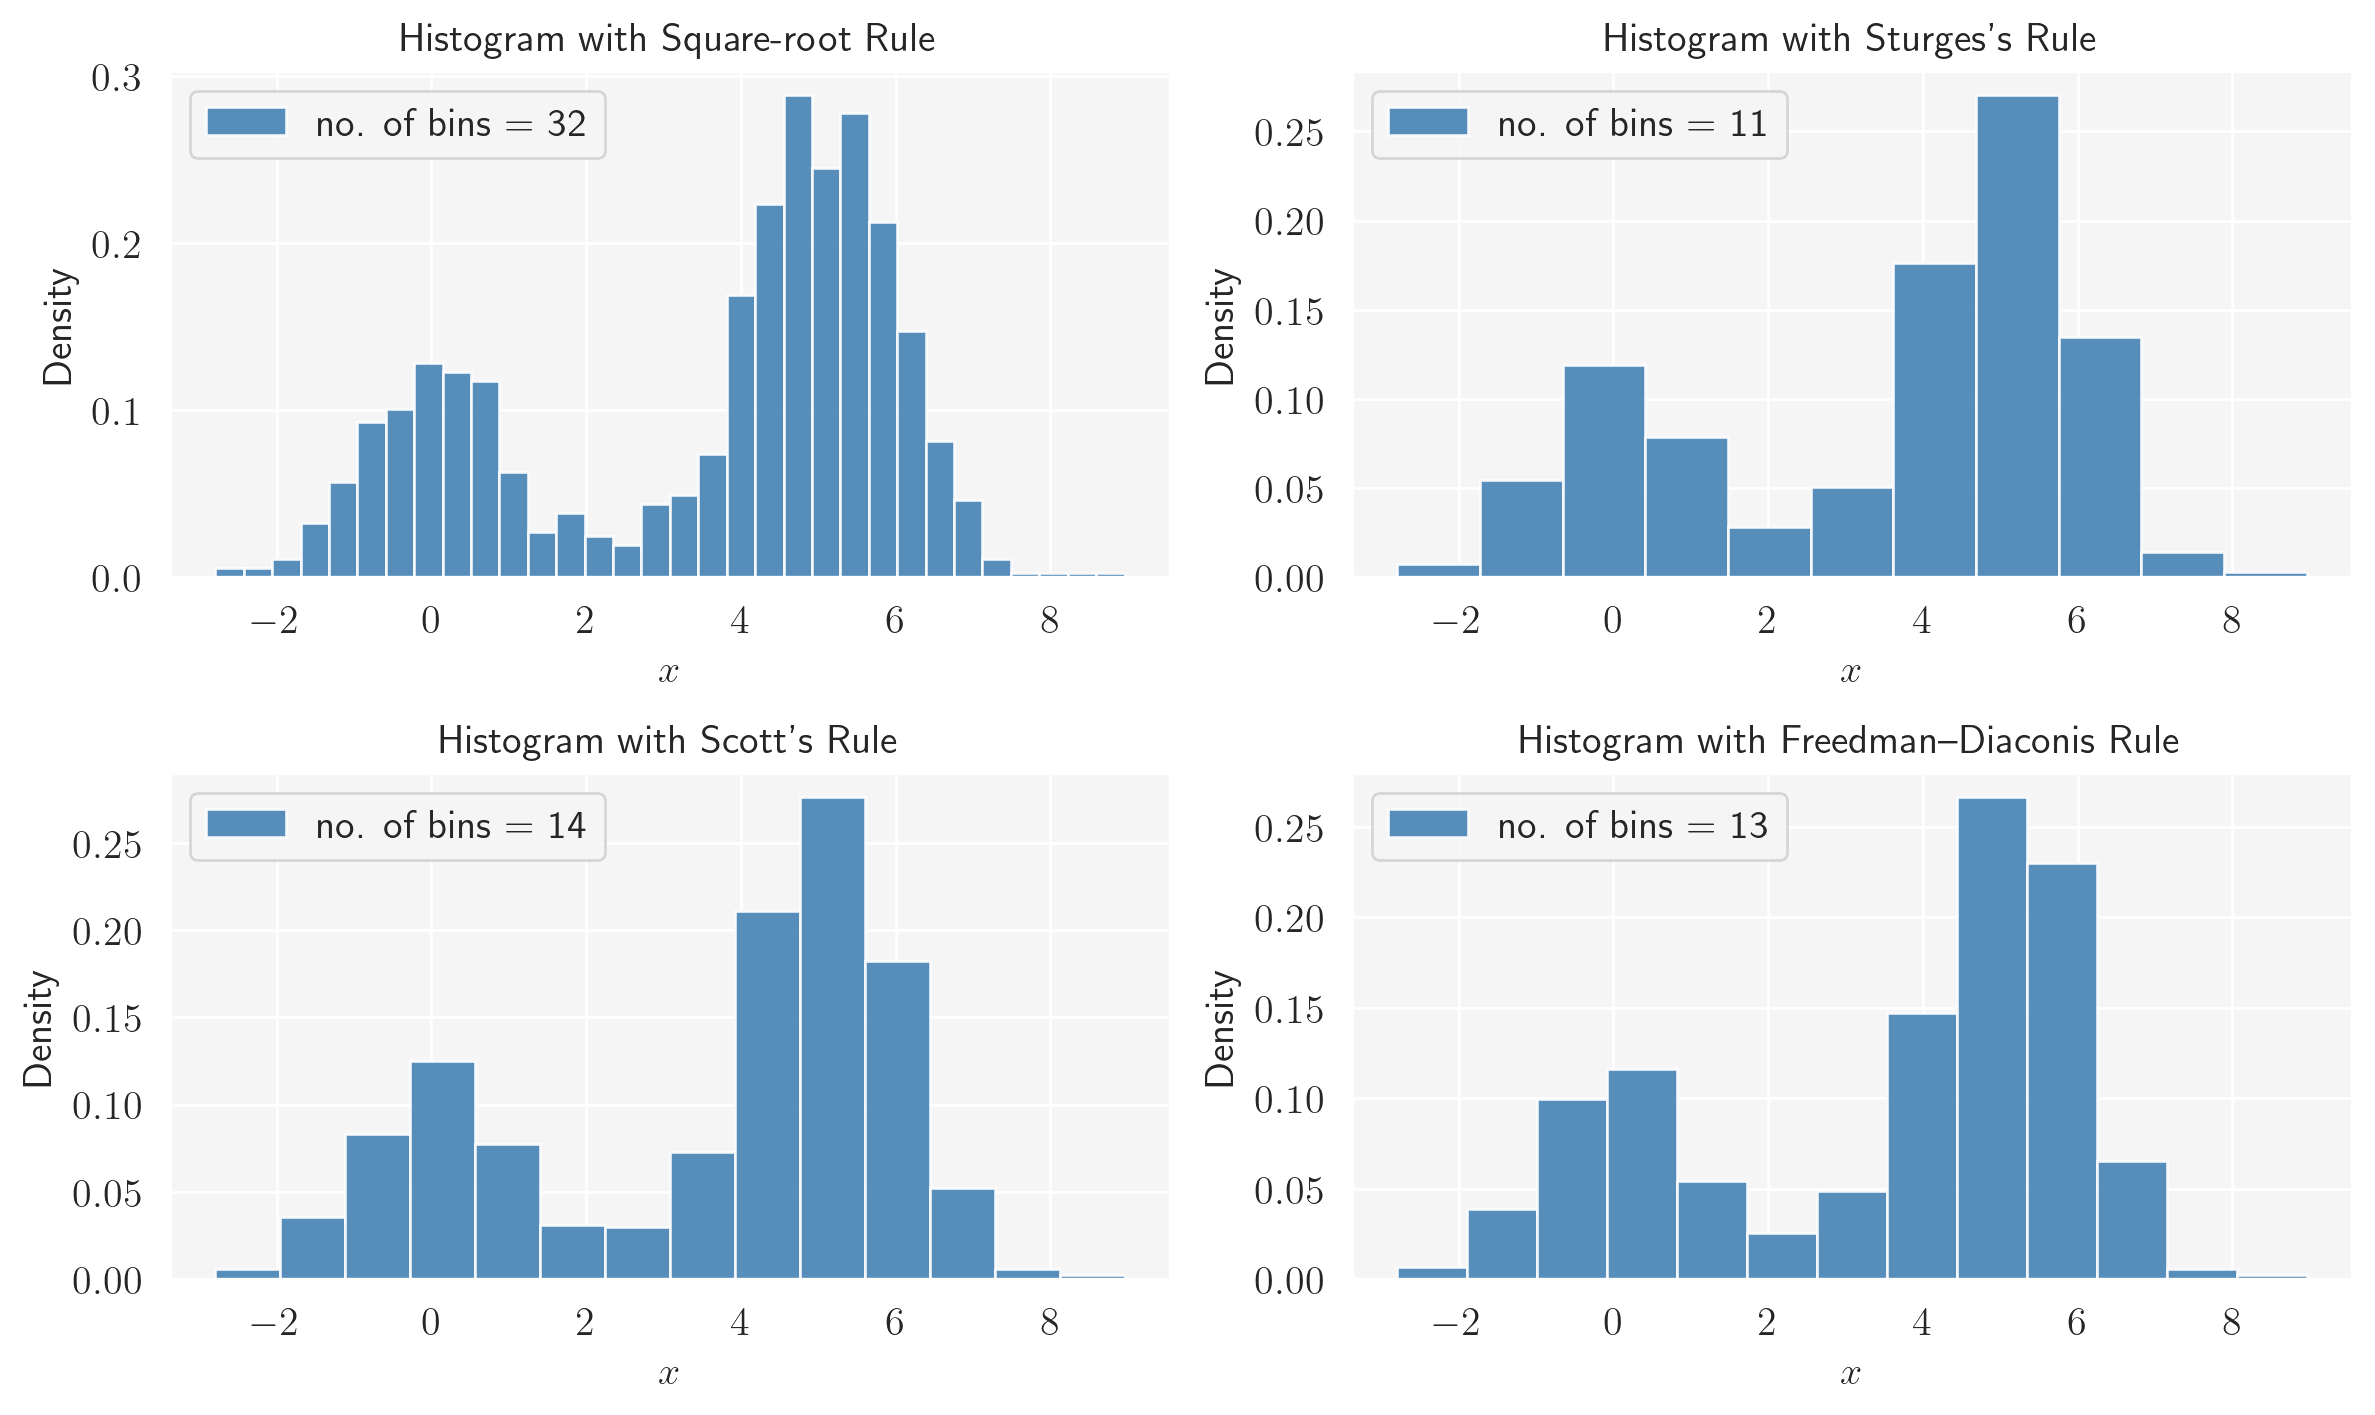

In [10]:
x = make_data(1000)

rules = [square_root_rule, sturges_rule, scotts_rule, freedman_diaconis_rule]
rule_names = [
    "Square-root Rule", "Sturges's Rule", "Scott's Rule",
    "Freedman–Diaconis Rule"
]

fig = plt.figure(figsize=(10, 6), tight_layout=True, dpi=120)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

for i, rule in enumerate(rules):
    ax = fig.add_subplot(gs[i])
    bins = rule(x)
    ax.hist(x,
            bins=bins,
            density=True,
            histtype='bar',
            edgecolor=None,
            color='steelblue',
            alpha=0.9,
            label=f"no. of bins = {bins}")
    #ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_xlabel("$x$")
    ax.set_ylabel("Density")
    ax.legend(loc="upper left")
    ax.set_title("Histogram with " + rule_names[i])
    
plt.show()
figcaption("Histograms as dictated by the rule specified in the subplot titles.")

Histograms give a rough sense of the density of the underlying distribution of the data, and often for density estimation: estimating the probability density function of the underlying variable. The total area of a histogram used for probability density is always normalized to 1. If the length of the intervals on the x-axis are all 1, then a histogram is identical to a relative frequency plot.

A histogram can be thought of as a simplistic kernel density estimation, which uses a kernel to smooth frequencies over the bins. This yields a smoother probability density function, which will in general more accurately reflect distribution of the underlying variable. The density estimate could be plotted as an alternative to the histogram, and is usually drawn as a curve rather than a set of boxes. Histograms are nevertheless preferred in applications, when their statistical properties need to be modeled. The correlated variation of a kernel density estimate is very difficult to describe mathematically, while it is simple for a histogram where each bin varies independently. 

--- 

Though rules-of-thumb like Scott’s rule and the Freedman-Diaconis rule are fast and convenient, their strong assumptions about the data make them suboptimal for more complicated distributions. Other methods of bin selection use fitness functions computed on the actual data to choose an optimal binning. Astropy implements two of these examples: Knuth’s rule (implemented in knuth_bin_width()) and Bayesian Blocks (implemented in bayesian_blocks()).

https://docs.astropy.org/en/stable/visualization/histogram.html?fbclid=IwAR1qgq-CS2YLA3ui_03P9oRDcKiHXf7XE5lLYuglSjtLEXjtDSp7QBAKYag#bayesian-models

https://www.astroml.org/user_guide/density_estimation.html?fbclid=IwAR24wrXL_hTLJ8iLkzfMczUc7nUAc5elXgxpimT-A341NVaYuNKHJalXKsA#kernel-density-estimation

https://seaborn.pydata.org/tutorial/distributions.html?fbclid=IwAR3VjoNoDOcWeaERXvICVx_NL9DJ-tqhd1gBW6emPrrffgD1-0sZwtzn91I

---

A rug plot is a plot of data for a single quantitative variable, displayed as marks along an axis. It is used to visualise the distribution of the data. As such it is analogous to a histogram with zero-width bins, or a one-dimensional scatter plot.

Rug plots are often used in combination with two-dimensional scatter plots by placing a rug plot of the x values of the data along the x-axis, and similarly for the y values. This is the origin of the term "rug plot", as these rug plots with perpendicular markers look like tassels along the edges of the rectangular "rug" of the scatter plot.

# Kernel Density Estimation 

Histograms have been a popular visualization option since at least the 18th century, in part because they are easily generated by hand. More recently, as extensive computing power has become available in everyday devices such as laptops and cell phones, we see them increasingly being replaced by density plots. In a density plot, we attempt to visualize the underlying probability distribution of the data by drawing an appropriate continuous curve (Figure 7.3). This curve needs to be estimated from the data, and the most commonly used method for this estimation procedure is called kernel density estimation. In kernel density estimation, we draw a continuous curve (the kernel) with a small width (controlled by a parameter called bandwidth) at the location of each data point, and then we add up all these curves to obtain the final density estimate

Analogous to the binwidth of a histogram, a density plot has a parameter called the bandwidth that changes the individual kernels and significantly affects the final result of the plot. The plotting library will choose a reasonable value of the bandwidth for us (by default using the ‘scott’ estimate)

With many data points the rug plot can become overcrowded, but for some datasets, it can be helpful to view every data point. The rug plot also lets us see how the density plot “creates” data where none exists because it makes a kernel distribution at each data point. These distributions can leak over the range of the original data and give the impression that Alaska Airlines has delays that are both shorter and longer than actually recorded. We need to be careful about this artifact of density plots and point it out to viewers!


https://github.com/COINtoolbox/CosmoABC/blob/master/cosmoabc/weighted_gaussian_kde.py see set bandwidth function

Generating a sample from Epanechnikov's kernel: https://stats.stackexchange.com/questions/173637/generating-a-sample-from-epanechnikovs-kernel


# References 

[1] https://ned.ipac.caltech.edu/level5/March02/Silverman/paper.pdf

[2] Python Data Science Handbook by Jake VanderPlas

[3] STK bok

[4] https://clauswilke.com/dataviz/histograms-density-plots.html

**Original papers:** 

Scott, D. (1979). On optimal and data-based histograms http://biomet.oxfordjournals.org/content/66/3/605

Freedman, D. & Diaconis, P. (1981). On the histogram as a density estimator: L2 theory http://www.springerlink.com/content/mp364022824748n3/ 

**See also SNL thesis:** Primer on density estimation (parametric/non-parametric) and includes neural density estimators. 

**Misc. sources:**

Python Data Science Handbook by Jake VanderPlas

https://clauswilke.com/dataviz/histograms-density-plots.html

https://ned.ipac.caltech.edu/level5/March02/Silverman/paper.pdf

http://users.stat.ufl.edu/~rrandles/sta6934/smhandout.pdf

---

https://jakevdp.github.io/PythonDataScienceHandbook/04.05-histograms-and-binnings.html

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

https://seaborn.pydata.org/tutorial/distributions.html

https://www.astroml.org/user_guide/density_estimation.html#kernel-density-estimation

https://docs.astropy.org/en/stable/visualization/histogram.html#bayesian-models

https://machinelearningmastery.com/probability-density-estimation/

https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram/33459231

https://stackoverflow.com/questions/30145957/plotting-2d-kernel-density-estimation-with-python